In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4)

from util import util
import os
import numpy as np
import pandas as pd
data_folder = os.path.join('..', 'data')
file_name = "Data"

# Match Predictor

Predicting the outcome of a football match is an important challenge withing the sports betting industry. The goal of a betting company is to produce odds that accurately measure the probability of each outcome of a match, in order to provide good and profitable odds to customers.

Predicitng an outcome of a football match is made significanlty more difficult by the result being highly dependent on individual coincidences and random events. With this in mind, picking an outcome might be very inaccurate. We will dig into different metrics and approaches, in a hope to find a fitting way to predict the outcome of a football match.

Initially, by random picking, the probability of either a home win, a draw, or an away win, is 33%. Our goal is predict the outcome of a match with a higher accuracy than this.

## The Dataset

To predict the outcome, we will use historic football matches as data. We fetch it from [football-data.co.uk](https://www.football-data.co.uk). For our use, we will use the last 19 seasons of the top four division in the English league system. This means we will use data from the Premier League, Championship, League One, and League Two, from 05/06 season to 23/24 season. In total it accumulates to approximately 40 000 matches. The dataset also includes different stats about the match. This will be important for our predictions.

In [2]:
#NB: Only run this cell if you want to re-fetch the data from the web
leagues = ['E0', 'E1', 'E2', 'E3']
start_year, end_year = 2005, 2024
util.fetch_data_into_file(data_folder=data_folder, file_name=file_name, start_year=start_year, end_year=end_year, leagues=leagues)

Data fetched and saved to ../data/Data.csv


## Inspecting the dataset

In [3]:
data = util.load_data(data_folder, file_name)
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,E0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,...,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,0506
1,E0,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,A,...,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,0506
2,E0,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,...,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,0506
3,E0,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,...,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,0506
4,E0,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,...,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,0506


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38427 entries, 0 to 38426
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Div       38420 non-null  object        
 1   Date      38420 non-null  datetime64[ns]
 2   HomeTeam  38420 non-null  object        
 3   AwayTeam  38420 non-null  object        
 4   FTHG      38420 non-null  float64       
 5   FTAG      38420 non-null  float64       
 6   FTR       38420 non-null  object        
 7   HTHG      38419 non-null  float64       
 8   HTAG      38419 non-null  float64       
 9   HTR       38419 non-null  object        
 10  Referee   36763 non-null  object        
 11  HS        38419 non-null  float64       
 12  AS        38419 non-null  float64       
 13  HST       38419 non-null  float64       
 14  AST       38419 non-null  float64       
 15  HF        38417 non-null  float64       
 16  AF        38417 non-null  float64       
 17  HC        38

There are some rows with missing values. We see there are many matches without a referee. We change the nan-value to Unknown

In [5]:
data['Referee'] = data['Referee'].fillna('Unknown')

Now, lets see the rest of the rows

In [6]:
data[data.isna().any(axis=1)]

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
15736,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1213
16289,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1213
16290,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1213
18707,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1415
19260,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1415
21849,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1516
22402,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1516
24410,E3,2017-04-22,Luton,Notts County,2.0,1.0,H,2.0,1.0,H,...,4.0,NaN,NaN,5.0,12.0,1.0,4.0,1.0,0.0,1617
24419,E3,2017-04-29,Cheltenham,Hartlepool,1.0,0.0,H,1.0,0.0,H,...,6.0,NaN,NaN,3.0,4.0,0.0,2.0,0.0,0.0,1617
27382,E1,2019-04-27,Bolton,Brentford,0.0,1.0,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1819


Many are plain errors, while a few are missing some values. We remove the error-rows, but keep the three others for now, as the result is important

In [7]:
data = data.dropna(subset=['HomeTeam'])
data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,E0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,...,6.0,14.0,16.0,7.0,8.0,0.0,2.0,0.0,0.0,0506
1,E0,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,A,...,5.0,15.0,14.0,8.0,6.0,3.0,1.0,0.0,0.0,0506
2,E0,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,...,4.0,12.0,13.0,6.0,6.0,1.0,2.0,0.0,0.0,0506
3,E0,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,...,3.0,13.0,11.0,3.0,6.0,2.0,3.0,0.0,0.0,0506
4,E0,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,...,7.0,17.0,11.0,5.0,0.0,2.0,3.0,1.0,0.0,0506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38422,E3,2024-04-27,Gillingham,Doncaster,2.0,2.0,D,0.0,2.0,A,...,4.0,11.0,12.0,7.0,5.0,2.0,1.0,0.0,1.0,2324
38423,E3,2024-04-27,Milton Keynes Dons,Sutton,4.0,4.0,D,2.0,0.0,H,...,12.0,10.0,13.0,3.0,9.0,2.0,2.0,0.0,0.0,2324
38424,E3,2024-04-27,Salford,Harrogate,2.0,2.0,D,2.0,2.0,D,...,4.0,13.0,9.0,2.0,8.0,0.0,2.0,0.0,0.0,2324
38425,E3,2024-04-27,Swindon,Morecambe,3.0,3.0,D,2.0,2.0,D,...,6.0,5.0,12.0,7.0,7.0,1.0,0.0,0.0,0.0,2324


We are given 24 columns, all with different abbreviations. The full names are as follow:
-   Div = League Division
-   Date = Match Date
-   HomeTeam = Home Team
-   AwayTeam = Away Team
-   FTHG = Full Time Home Team Goals
-   FTAG = Full Time Away Team Goals
-   FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
-   HTHG = Half Time Home Team Goals
-   HTAG = Half Time Away Team Goals
-   HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)
-   Referee = Match Referee
-   HS = Home Team Shots
-   AS = Away Team Shots
-   HST = Home Team Shots on Target
-   AST = Away Team Shots on Target
-   HF = Home Team Fouls Committed
-   AF = Away Team Fouls Committed
-   HC = Home Team Corners
-   AC = Away Team Corners
-   HY = Home Team Yellow Cards
-   AY = Away Team Yellow Cards
-   HR = Home Team Red Cards
-   AR = Away Team Red Cards
- 	Season = Season


Some key takeaways to know initially: Teams are either a HomeTeam or AwayTeam for a match. To get all their previous matches, we would have to search within both columns and order by the date. To get all teams however, we would only need to get the unique vlaues of either one of the columns, as all teams have been a HomeTeam or AwayTeam.

## Data exploration

Now, let's look deeper into the data at hand

In [8]:
data.describe()

,Date,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,38420,38420.000000,38420.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38417.000000,38417.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000,38419.000000
mean,2014-12-14 15:04:55.720978432,1.447137,1.157184,0.641297,0.507041,12.609256,10.339962,5.260548,4.292564,11.068980,11.632376,5.849658,4.836279,1.402145,1.723392,0.065046,0.093235
min,2005-08-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010-03-06 00:00:00,1.000000,0.000000,0.000000,0.000000,9.000000,7.000000,3.000000,2.000000,8.000000,9.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000
50%,2014-12-13 00:00:00,1.000000,1.000000,0.000000,0.000000,12.000000,10.000000,5.000000,4.000000,11.000000,11.000000,6.000000,5.000000,1.000000,2.000000,0.000000,0.000000
75%,2019-09-15 06:00:00,2.000000,2.000000,1.000000,1.000000,16.000000,13.000000,7.000000,6.000000,13.000000,14.000000,8.000000,6.000000,2.000000,3.000000,0.000000,0.000000
max,2024-05-19 00:00:00,9.000000,9.000000,7.000000,5.000000,43.000000,35.000000,24.000000,20.000000,33.000000,77.000000,24.000000,21.000000,11.000000,9.000000,2.000000,3.000000
std,NaN,1.225458,1.096288,0.804254,0.713663,4.834688,4.343935,2.876526,2.507896,3.662132,3.779600,2.937173,2.652718,1.171606,1.285655,0.256035,0.308234


A takeway is that the home team seem to have an advantage in the statistics, as the mean of positive staistics are higher, and the mean of negative statistics are lower.

For example, the mean of home team goals is higher than the mean of away team foals. But the stadnard deviation is also higher.

In [9]:
home_factor, draw_factor, away_factor = data['FTR'].value_counts(normalize=True)['H'], data['FTR'].value_counts(normalize=True)['D'], data['FTR'].value_counts(normalize=True)['A']
print(f'The precentage of matches where the home team wins is {home_factor*100:.2f}%\nThe precentage of matches where the match ends in a draw is {draw_factor*100:.2f}%\nThe precentage of matches where the away team wins is {away_factor*100:.2f}%.')

The precentage of matches where the home team wins is 43.46%
The precentage of matches where the match ends in a draw is 26.45%
The precentage of matches where the away team wins is 30.09%.


By looking at the share of outcomes we can see the result of the advantage described by the stats.

Let's look at the distribution of some key stats

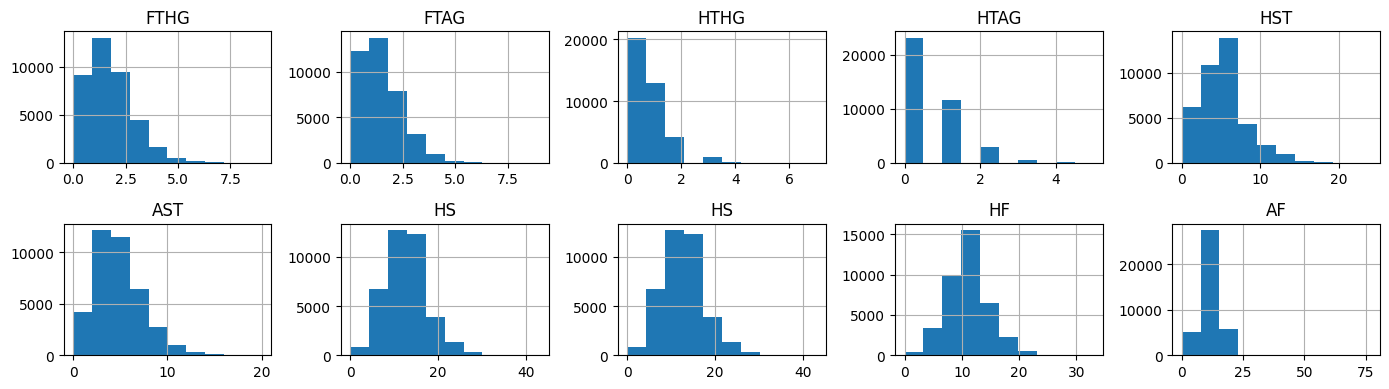

In [10]:
util.plot_sub_plots(data, ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HST', 'AST', 'HS', 'HS', 'HF', 'AF'], figsize=figsize)

Many follow a Gaussian distribution. However, an important insight is what happens if you compare the stats of the home team and the away team. Lets look at Goal difference

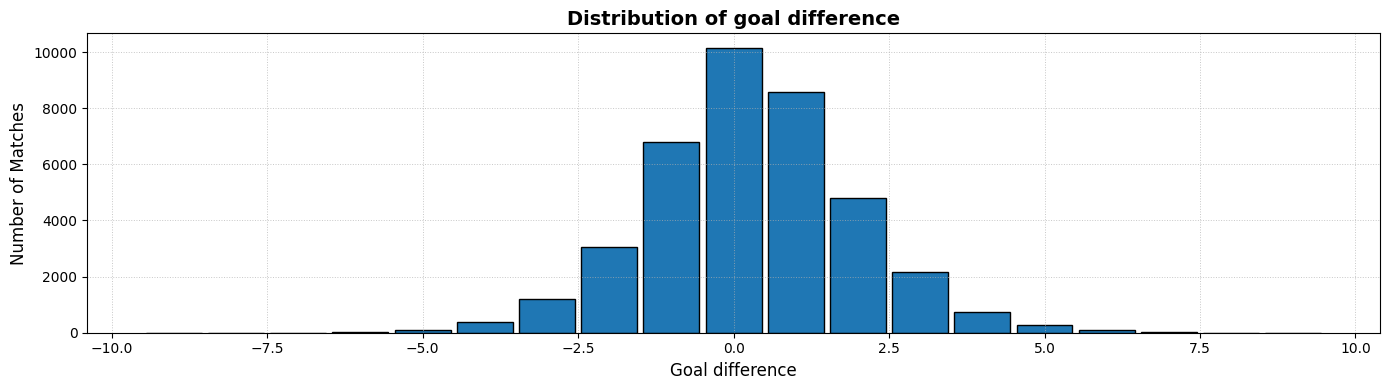

In [11]:
data['Goal difference'] = data['FTHG'] - data['FTAG']
util.plot_histogram(data['Goal difference'], figsize=figsize, xlabel='Goal difference', title='Distribution of goal difference')

It transforms from two skewed distributions, to one Gaussian, with a slight bias. This is a case for many of the stats.

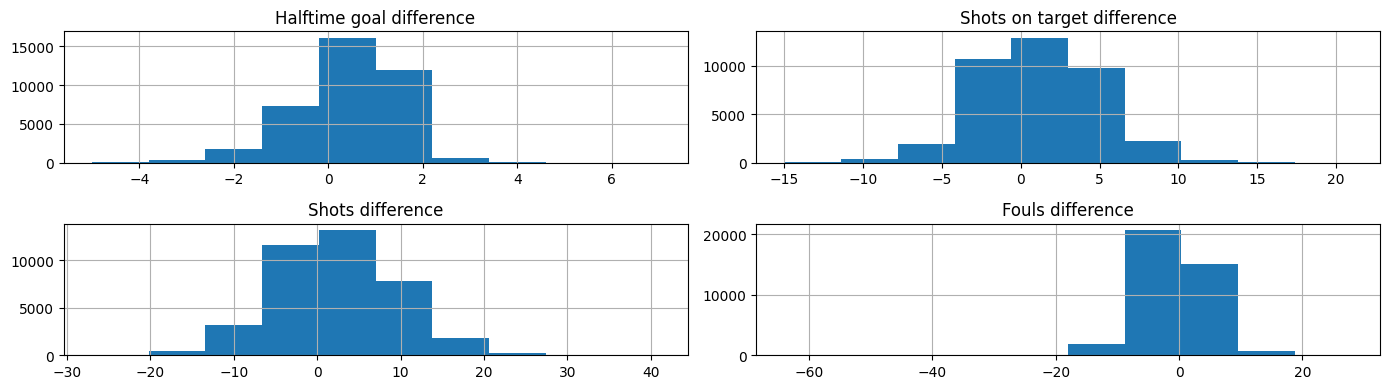

In [12]:
data['Halftime goal difference'] = data['HTHG'] - data['HTAG']
data['Shots on target difference'] = data['HST'] - data['AST']
data['Shots difference'] = data['HS'] - data['AS']
data['Fouls difference'] = data['HF'] - data['AF']
util.plot_sub_plots(data, ['Halftime goal difference', 'Shots on target difference', 'Shots difference', 'Fouls difference'], figsize=figsize)

## Setting a bottom line

To set a bottom line of predictions, lets use the distribution of the outcomes to create a probability. As a simple way to measure the accuracy of the predictions, we will for each match pick the outcome with the highest probability, and compare it to the actual outcome. This will give us a percentage of correct predictions.

In [13]:
data['Home Prob'] = home_factor
data['Draw Prob'] = draw_factor
data['Away Prob'] = away_factor
data.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AR,Season,Goal difference,Halftime goal difference,Shots on target difference,Shots difference,Fouls difference,Home Prob,Draw Prob,Away Prob
0,E0,2005-08-13,Aston Villa,Bolton,2.0,2.0,D,2.0,2.0,D,...,0.0,0506,0.0,0.0,-4.0,-10.0,-2.0,0.434591,0.264524,0.300885
1,E0,2005-08-13,Everton,Man United,0.0,2.0,A,0.0,1.0,A,...,0.0,0506,-2.0,-1.0,0.0,-2.0,1.0,0.434591,0.264524,0.300885
2,E0,2005-08-13,Fulham,Birmingham,0.0,0.0,D,0.0,0.0,D,...,0.0,0506,0.0,0.0,3.0,8.0,-1.0,0.434591,0.264524,0.300885
3,E0,2005-08-13,Man City,West Brom,0.0,0.0,D,0.0,0.0,D,...,0.0,0506,0.0,0.0,5.0,2.0,2.0,0.434591,0.264524,0.300885
4,E0,2005-08-13,Middlesbrough,Liverpool,0.0,0.0,D,0.0,0.0,D,...,0.0,0506,0.0,0.0,-5.0,-12.0,6.0,0.434591,0.264524,0.300885


In [14]:
correct = 0
wrong = 0
for index,row in data.iterrows():
	max_prob = max(row['Home Prob'], row['Draw Prob'], row['Away Prob'])
	if (row['Home Prob'] == max_prob and row['FTR'] == 'H') or (row['Draw Prob'] == max_prob and row['FTR'] == 'D') or (row['Away Prob'] == max_prob and row['FTR'] == 'A'):
		correct += 1
	else:
		wrong += 1
print(f'The model correctly predicted {correct} matches and incorrectly predicted {wrong} matches.')
print(f'The model picks {correct/(correct+wrong)*100:.2f}% outcomes correctly.')


The model correctly predicted 16697 matches and incorrectly predicted 21723 matches.
The model picks 43.46% outcomes correctly.


Let's improve by modelling a teams form instead